In [25]:
#Imports from project
from import_images import import_images_from_path
from cellpose_data import get_cellpose_probability_maps
from random_crops import get_random_crops_from_multiple_images
from augment_data import rotate_images_and_cellprobs_return_merged
from u_net import UNet

#Import from other libraries
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.optim import Adam
import wandb

In [2]:
#File directories
images_path = 'data/'

In [3]:
#Importing images
images = import_images_from_path(images_path,num_imgs=23,normalisation=True)

In [4]:
#Getting groundtruth data from images with Cellpose
cell_probabilities = get_cellpose_probability_maps(images)

In [5]:
#Normalise the cell_probabilities to be between 0 and 1
cell_probabilities_norm = [(cellprob-np.min(cellprob))/(np.max(cellprob)-np.min(cellprob)) for cellprob in cell_probabilities]

In [6]:
#Getting tensor crops of 128x128 from images
image_crops, cellprob_crops = get_random_crops_from_multiple_images(images,cell_probabilities_norm,num_crops=10)

In [7]:
#Augmenting the data
image_crops_augmented, cellprob_crops_augmented = rotate_images_and_cellprobs_return_merged(image_crops,cellprob_crops,angles=[90,180,270])

In [8]:
#Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(image_crops_augmented, cellprob_crops_augmented, test_size=0.33, random_state=42)

In [49]:
print(torch.unsqueeze(y_test[0],0).shape)

torch.Size([1, 128, 128])


In [51]:
print(y_test[0])

tensor([[0.4955, 0.5233, 0.5338,  ..., 0.6033, 0.6095, 0.6272],
        [0.4959, 0.5168, 0.5336,  ..., 0.6225, 0.6283, 0.6436],
        [0.4990, 0.5109, 0.5348,  ..., 0.6394, 0.6462, 0.6597],
        ...,
        [0.5211, 0.5235, 0.5257,  ..., 0.3105, 0.3053, 0.3036],
        [0.5233, 0.5265, 0.5272,  ..., 0.3125, 0.3055, 0.3028],
        [0.5329, 0.5323, 0.5304,  ..., 0.3195, 0.3101, 0.3054]],
       device='cuda:0')


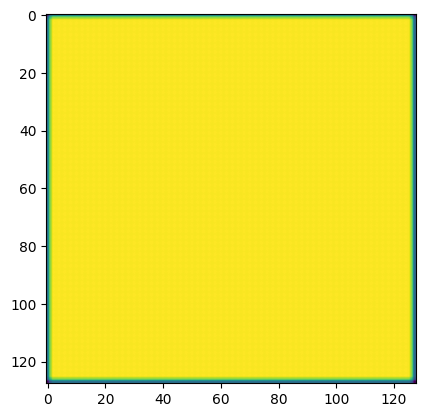

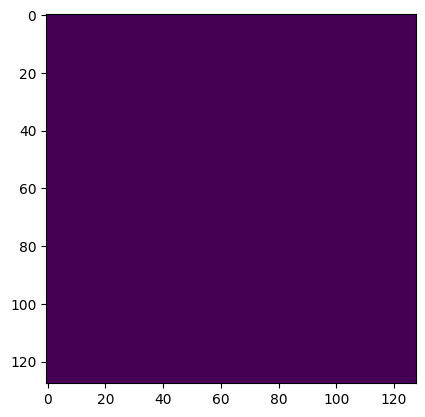

In [66]:
import matplotlib.pyplot as plt
pred = model(torch.unsqueeze(torch.unsqueeze(y_test[2],0),0))
plt.imshow(pred.cpu().detach()[0][0])
plt.show()

plt.imshow(torch.nn.Sigmoid()(pred.cpu().detach()[0][0]))
plt.show()

In [35]:
#Hyperparameters
learning_rate = 0.1
num_epochs = 10
batch_size = 32
loss_fn = torch.nn.MSELoss() #check in WANDB
activation_fn = torch.nn.Sigmoid()

#WANDB
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cell-probability-map-U-Net",
    
    # track hyperparameters and run metadata
    config={
    "learning rate": learning_rate,
    "epochs": num_epochs,
    "batch size": batch_size,
    "loss function": loss_fn,
    "number of training images":len(X_train),
    #VARIABLES TO CHECK
    "loss function": "MSE",
    "activation function": "Sigmoid",
    "size of crops": "128x128",
    "transformations": "rotations",
    }
)

#Initialising the model, we might need to do 256x256 crops in the end
model = UNet()
model = model.to('cuda:0')

#Get the dataloaders
train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test,y_test)), batch_size=32, shuffle=True)

#Optimiser
opt = Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    total_train_loss_per_epoch = 0
    for i, (images, cellprobs) in enumerate(train_loader):
        opt.zero_grad()
        images = torch.unsqueeze(images,1)
        outputs = model(images)
        outputs = activation_fn(outputs)
        loss = loss_fn(outputs, cellprobs)
        total_train_loss_per_epoch += loss.item()
        loss.backward()
        opt.step()
    total_train_loss_per_epoch /= len(train_loader)
    wandb.log({"train loss": total_train_loss_per_epoch})
    train_losses.append(total_train_loss_per_epoch)
    
    #get test loss
    total_test_loss_per_epoch = 0
    with torch.no_grad():
        for images, cellprobs in test_loader:
            images = torch.unsqueeze(images,1)
            outputs = model(images)
            outputs = activation_fn(outputs)
            loss = loss_fn(outputs, cellprobs)
            total_test_loss_per_epoch += loss.item()
    total_test_loss_per_epoch /= len(test_loader)
    wandb.log({"test loss": total_test_loss_per_epoch})
    test_losses.append(total_test_loss_per_epoch)

    print('Epoch: {}/{} | Train Loss: {:.4f} | Test Loss: {:.4f}'.format(epoch+1, num_epochs, total_train_loss_per_epoch, total_test_loss_per_epoch))

wandb.finish()
    #might be iunteresting to get a prediction at each epoch from the test loss and visualise it to track its progress

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([32, 128, 128])) that is different to the input size (torch.Size([32, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1930, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(7.8146e+11, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1899e+19, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(3.5235e+16, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5.0694e+18, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.2888, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3656, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4007, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4008, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3943, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3994, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4037, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.4336, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.7662, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(20.5787, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(129.5825, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1618.1283, dev

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([8, 128, 128])) that is different to the input size (torch.Size([8, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([16, 128, 128])) that is different to the input size (torch.Size([16, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/10 | Train Loss: 850165741248530432.0000 | Test Loss: 40035.6152
tensor(42577.4102, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(61701.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(94750.9922, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(124483.5938, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(170801.9688, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(204515.7188, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(261438.9062, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(301745., device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(329122.2188, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(409612.1562, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(458694.1250, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(506298.4375, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(528560.7500, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(617428.5000, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(678475.5625, dev

test loss,▁▆████████
train loss,█▁▁▁▁▁▁▁▁▁
test loss,1293506.0375
train loss,1319249.90625
